# Unsupervised classifcation with ISO clustering algorithm

In [81]:
import os
import json

# import arcgis libraries
import arcpy
from arcgis.gis import GIS
from arcgis import raster
from arcgis.features import GeoAccessor
import pandas as pd

# import plotting libs
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
# setup workspace
data_path = r'Y:\Documents\GIS_data\Imagery\arcgis-tutorial\ImageClassUnsuperPB\Data'
landsat_file = os.path.join(data_path, 'Landsat','LC80340322015090LGN00_MTL.txt')
landsat_ms_file = os.path.join(landsat_file, 'Multispectral')

ecd_path = os.path.join(data_path, 'iso_classes.ecd')
output_ras = os.path.join(data_path, 'iso_classified_ras.tif')
output_shp = os.path.join(data_path, 'iso_classified_poly.shp')

In [21]:
ras1 = raster.Raster(landsat_file)
ms_ras1 = raster.Raster(landsat_ms_file)

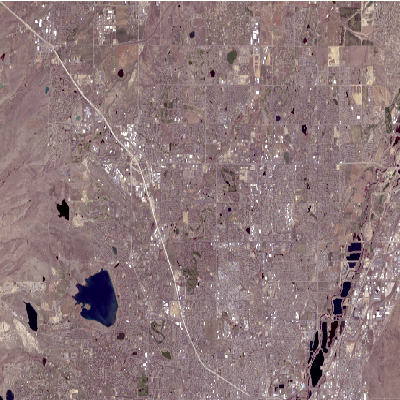

In [7]:
ras1

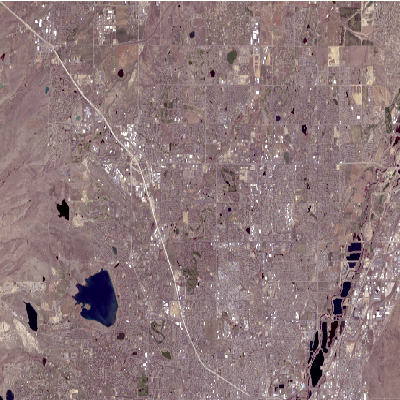

In [22]:
ms_ras1

In [23]:
(ras1.band_count, ms_ras1.band_count)

(8, 8)

In [9]:
ras1.band_names

['CoastalAerosol',
 'Blue',
 'Green',
 'Red',
 'NearInfrared',
 'ShortWaveInfrared_1',
 'ShortWaveInfrared_2',
 'Cirrus']

### Train ISO classifier

In [28]:
a_ms_ras = ms_ras1._engine_obj._raster
type(a_ms_ras)

arcpy.sa.Raster.Raster

In [24]:
from arcpy.sa import TrainIsoClusterClassifier

In [29]:
%%time
TrainIsoClusterClassifier(in_raster=a_ms_ras, max_classes=10, out_classifier_definition=ecd_path,
                         max_iterations=25, min_samples_per_cluster=100)

Wall time: 4.08 s


<geoprocessing server result object at 0x19befea1198>

#### Exploring the ECD file (Esri Classifier Definition)

In [32]:
ecd_path

'Y:\\Documents\\GIS_data\\Imagery\\arcgis-tutorial\\ImageClassUnsuperPB\\Data\\iso_classes.ecd'

In [35]:
with open(ecd_path, 'r') as read_handle:
    ecd_dict = json.load(read_handle)

ecd_dict.keys()

dict_keys(['EsriClassifierDefinitionFile', 'FileVersion', 'NumberDefinitions', 'Definitions'])

In [37]:
ecd_dict['Definitions'][0].keys()

dict_keys(['Classifier', 'NumberClasses', 'RasterIsSegmented', 'NumberBands', 'Classes', 'Mins', 'Maxs', 'Raster1', 'IsoParams_MaxNumClasses', 'IsoParams_MaxNumIterations', 'IsoParams_MaxNumMergesPerIteration', 'IsoParams_MaxMergeDistance', 'IsoParams_MinNumPointsPerCluster', 'IsoParams_SkipFactor', 'MLC_Stats'])

In [38]:
ecd_dict['Definitions'][0]['NumberClasses']

8

In [51]:
print(len(ecd_dict['Definitions'][0]['MLC_Stats']))

8


In [44]:
class_means = [i['Means'] for i in ecd_dict['Definitions'][0]['MLC_Stats']]
len(class_means)

8

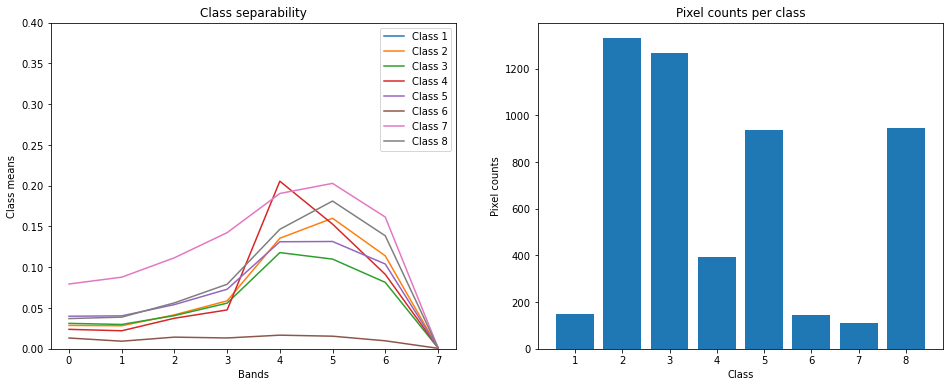

In [64]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
for index, e in enumerate(ecd_dict['Definitions'][0]['MLC_Stats']):
    ax[0].plot(e['Means'], label="Class "+str(index+1))
ax[0].legend(loc=0)
ax[0].set_ylim(0,0.4)
ax[0].set_xlabel('Bands')
ax[0].set_ylabel('Class means')
ax[0].set_title('Class separability');

class_counts = [i['Count'] for i in ecd_dict['Definitions'][0]['MLC_Stats']]
ax[1].bar(range(1,9),class_counts);
ax[1].set_title('Pixel counts per class')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Pixel counts');

### Classify raster

In [66]:
from arcpy.sa import ClassifyRaster
ClassifyRaster?

Wall time: 2.08 s


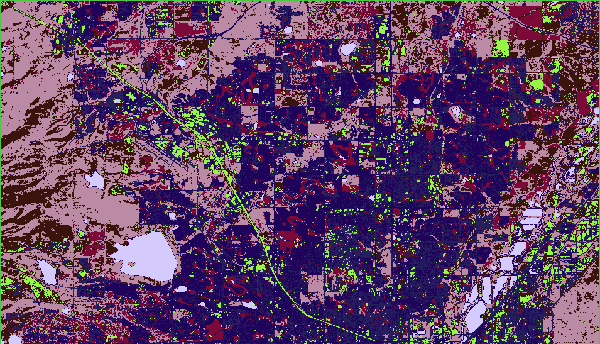

In [67]:
%%time
classified_ras = ClassifyRaster(in_raster=a_ms_ras, in_classifier_definition=ecd_path)
classified_ras

In [68]:
classified_ras.save(output_ras)

In [69]:
classified_ras2 = raster.Raster(classified_ras)

MapView(layout=Layout(height='400px', width='100%'))


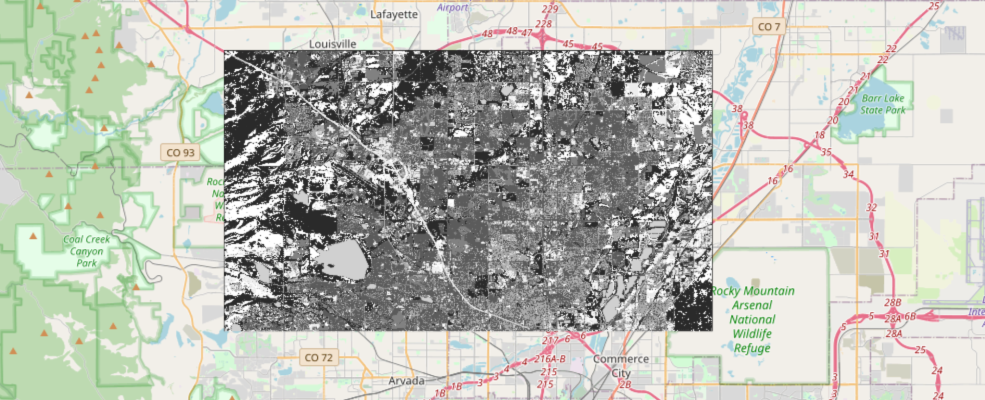

In [71]:
gis=GIS()
map1 = gis.map('Denver, CO')
map1

In [73]:
# map1.add_layer(classified_ras2)
map1.take_screenshot(False)

### Export to Vector

In [79]:
%%time
arcpy.conversion.RasterToPolygon(in_raster = classified_ras, 
                                 out_polygon_features=output_shp,simplify='SIMPLIFY')

Wall time: 8.43 s


<Result 'Y:\\Documents\\GIS_data\\Imagery\\arcgis-tutorial\\ImageClassUnsuperPB\\Data\\iso_classified_poly.shp'>

### Read vector and extract water bodies

In [82]:
sedf = pd.DataFrame.spatial.from_featureclass(output_shp)
sedf.head()

,FID,Id,gridcode,SHAPE
0,0,1,4,"{""rings"": [[[484335, 4424865], [484275, 442486..."
1,1,2,2,"{""rings"": [[[484335, 4424865], [484335, 442489..."
2,2,3,3,"{""rings"": [[[484755, 4424865], [484725, 442486..."
3,3,4,4,"{""rings"": [[[484875, 4424895], [484905, 442489..."
4,4,5,1,"{""rings"": [[[485115, 4424895], [485145, 442489..."


In [83]:
sedf.shape

(48664, 4)

MapView(layout=Layout(height='400px', width='100%'))


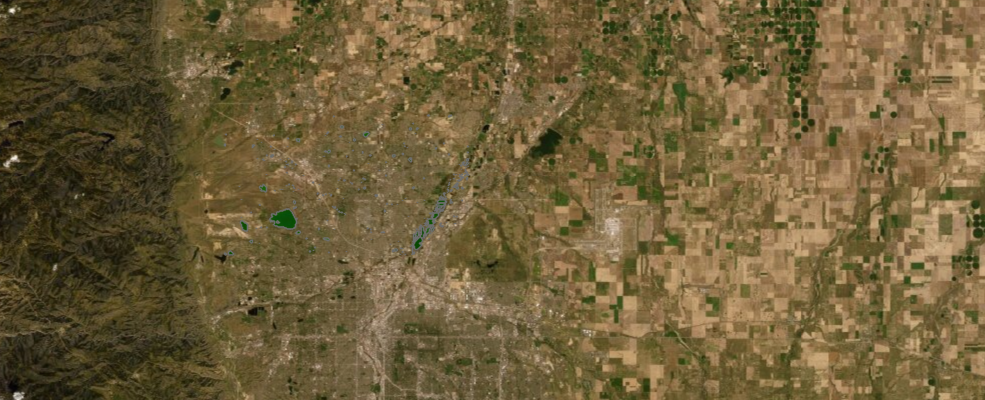

In [85]:
map2 = gis.map('Denver, CO')
map2.basemap = 'satellite'
map2

In [86]:
sedf.spatial.plot(map2)

True

In [87]:
water = sedf[sedf['gridcode']==5]
water.shape

(551, 4)

In [88]:
map2.remove_layers()

True

In [89]:
water.spatial.plot(map2)

C:\Users\atma6951\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone1\lib\site-packages\pandas\core\series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


True

In [90]:
map2.basemap='streets'
map2.take_screenshot(False)